# Transformer with Diffrence ID Dataset

In [3]:
from datetime import datetime
import json
import math
import os
import sys
import time

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch import Tensor
from torch.nn import (TransformerDecoder, TransformerDecoderLayer,
                      TransformerEncoder, TransformerEncoderLayer)
from torch.utils.data import DataLoader
from tqdm import tqdm

In [4]:
try:
  from google.colab import drive
  IS_GOOGLE_COLAB = True
except ImportError:
  IS_GOOGLE_COLAB = False

if IS_GOOGLE_COLAB:
  mount_path = '/content/drive'
  base_folder = os.path.join(mount_path, "My Drive", "Data")
  data_folder = os.path.join(base_folder, "FX")
else:
  base_folder = 'L:/data'
  data_folder = os.path.join(base_folder, "fx", "OANDA-Japan MT5 Live")


device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cpu


In [ ]:
model_name = "ohlc_did_transformer"
model_version = "1"
batch_first = True

# parameters for dataset
ohlc_column = ['open','high','low','close']
time_column = "time"
file_name = "mt5_USDJPY_min30.csv"
file_path = os.path.join(data_folder, file_name)
file_path = os.path.abspath(file_path)
clip_range = (-2, 2)
periods = 10

# training parameters
observation_length = 60
prediction_length = 10
lr = 0.001
batch_size = 64
epoch = 100
patience = 3
scheduler_gamma = 0.5

# model parameters
model_params = {
    "nhead": 4,
    "d_model": 120,
    "dim_feedforward": 10,
    "num_encoder_layers": 4,
    "num_decoder_layers": 4,
    # replace after dataset is defined
    "ohlc_size": None,
    "dropout": 0.1,
    "batch_first": batch_first,
}

In [6]:
import os
import shutil
import sys
import zipfile
import requests

def download_modlue_from_gh(repository, github_account='Naradice', branch='master', folder=None, module_path='/gdrive/My Drive/modules', **kwargs):
  if folder is None:
    folder = repository
  print(f"Downloading {repository} from {github_account}/{repository}/{branch}...")

  zip_url = f"https://github.com/{github_account}/{repository}/archive/refs/heads/{branch}.zip"
  response = requests.get(zip_url)
  if response.status_code == 200:
    with open("temp.zip", "wb") as f:
      f.write(response.content)
    with zipfile.ZipFile("temp.zip", "r") as zip_ref:
      zip_ref.extractall("temp_dir")

    if isinstance(folder, str):
      folders = [folder]
    else:
      folders = folder
    for folder in folders:    
      source_folder = f"temp_dir/{repository}-{branch}/{folder}"
      destination_folder = os.path.join(module_path, folder)
      print(f"Copying {source_folder} to {destination_folder}...")
      shutil.copytree(source_folder, destination_folder, dirs_exist_ok=True)
    os.remove("temp.zip")
    shutil.rmtree("temp_dir")
  else:
    print(f"filed to download {zip_url}: {response.status_code}, {response.text}")

In [7]:
if IS_GOOGLE_COLAB:
  drive.mount(mount_path)
  module_path = f"{mount_path}/My Drive/modules"
else:
  module_path = '../../modules'

if os.path.exists(module_path) is False:
  os.makedirs(module_path)

repositories = [
    {'repository': 'stocknet_study', 'branch': 'master', 'folder': ['Dataset', 'SN_Utils'], 'refresh': False},
    {'repository': 'finance_process', 'branch': 'master', 'folder': 'fprocess', 'refresh': False},
    {'repository': 'cloud_storage_handler', 'branch': 'main', 'folder': 'cloud_storage_handler', 'refresh': False},
]

destination = os.path.join(module_path, '__init__.py')
if os.path.exists(destination) is False:
  with open(destination, mode='w') as fp:
    fp.close()

for repo_kwargs in repositories:
  folders = repo_kwargs['folder']
  if isinstance(folders, str):
    folders = [folders]
  is_missing = False
  for folder in folders:
    destination = os.path.join(module_path, folder)
    if repo_kwargs['refresh'] or os.path.exists(destination) is False:
      is_missing = True
      break
  if is_missing:
    download_modlue_from_gh(**repo_kwargs, module_path=module_path)

In [8]:
sys.path.append(module_path)

import cloud_storage_handler
import SN_Utils

In [9]:
# Initialize cloud storage handler if needed
from cloud_storage_handler import DropboxHandler


# storage_handler = DropboxHandler("nhjrq1cjpugk5hc", "http://localhost")
# storage_handler.authenticate()
# Otherwise, specify None
storage_handler = None

## Define Dataset

In [87]:
import random
from collections.abc import Iterable

import numpy as np
import torch


class CloseDiffIDDS:
    
    def __init__(self, df, ohlc_columns, volume_column=None, spread_column=None, observation_length=60, periods=1, decimal_digits=3,
                device="cuda", future_step_size=1, seed=1017, is_training=True, batch_first=True, with_close=True, clip_range=None):
        self.seed(seed)
        self._BIAS = 10
        self.columns = ohlc_columns
        self.decimal_digits = decimal_digits
        self.__periods = periods
        self.__length_difference = 0
        self.__with_close = with_close
        self.__clip_range = clip_range
        self.__batch_first = batch_first
        self.__data = df.copy()
        self.ohlc_idf = self.__init_ohlc(df, ohlc_columns, decimal_digits=decimal_digits, with_close=with_close, clip_range=clip_range)
        
        self.observation_length = observation_length
        self.device = device
        self.future_step_size = future_step_size
        self.is_training = is_training
        self.__init_indicies(self.ohlc_idf)
    
    def __init_indicies(self, data, split_ratio=0.8):
        length = len(data) - self.observation_length - self.future_step_size
        if length < 0:
            raise Exception(f"date length {length} is less than observation_length {self.observation_length}")
        
        to_index = int(length * split_ratio)
        from_index = 0
        train_indices = list(range(from_index, to_index))
        self.train_indices = random.sample(train_indices, k=to_index - from_index)

        # Note: If unique value exits in validation data only, validation loss would be grater than expected
        from_index = int(length * split_ratio) + self.observation_length + self.future_step_size
        to_index = length
        eval_indices = list(range(from_index, to_index))
        self.eval_indices = random.sample(eval_indices, k=to_index - from_index)
        
        if self.is_training:
            self._indices = self.train_indices
        else:
            self._indices = self.eval_indices
    
    def __init_ohlc(self, df, ohlc_columns, decimal_digits = 3, with_close=True, clip_range=None):
        if with_close:
            close_column = [ohlc_columns[3]]
            ohlc_cls_diff_df = df[ohlc_columns].iloc[self.__periods:] - df[close_column].iloc[:-self.__periods].values
            self.__length_difference += self.__periods
        else:
            ohlc_cls_diff_df = df[ohlc_columns].diff(periods=self.__periods).dropna()
            self.__length_difference += self.__periods
        if clip_range is not None:
            ohlc_cls_diff_df = ohlc_cls_diff_df.clip(lower=clip_range[0], upper=clip_range[1])
        min_value = ohlc_cls_diff_df.min().min()
        min_value_abs = abs(min_value)

        self.__scale = 10 ** decimal_digits
        lower_value = math.ceil(min_value_abs) * self.__scale
        upper_value = math.ceil(ohlc_cls_diff_df.max().max()) * self.__scale
        self.ohlc_lower = lower_value
        id_df =  np.round(ohlc_cls_diff_df * self.__scale) + lower_value
        id_df = id_df.astype('int64')
        # add bias to avoid 0 value in the dataset
        self.ohlc_range_size = lower_value + upper_value + self._BIAS
        return id_df
    
    def revert_diff(self, prediction, index, periods=None):
        if periods is None:
            periods = self.__periods
        org_indices = self.get_actual_index(index)
        if self.__with_close:
            if type(org_indices) is int:
                target_index = self.get_target_range(org_indices).start - periods
                last_close = self.__data[self.columns[3]].iloc[target_index].values
            else:
                target_index = [self.get_target_range(i).start - periods for i in org_indices]
                batch_size = len(org_indices)
                last_close = self.__data[self.columns[3]].iloc[target_index].values.reshape(batch_size, 1)
            return last_close + prediction
        else:
            if type(org_indices) is int:
                target_index = self.get_target_range(org_indices).start - periods
                last_value = self.__data[self.columns].iloc[target_index].values
            else:
                target_index = [self.get_target_range(i).start - periods for i in org_indices]
                batch_size = len(org_indices)
                last_value = self.__data[self.columns].iloc[target_index].values.reshape(batch_size, len(self.columns))
            return prediction + last_value
    
    def revert_target(self, tgt_ohlc, indices):
        batch_size = len(indices)
        if self.__batch_first:
            tgt_ohlc = tgt_ohlc.transpose(0, 1)
        length = tgt_ohlc.size(0)
        tgt_batch_size = tgt_ohlc.size(1)
        if tgt_batch_size != batch_size:
            print(f"tgt_batch_size: {tgt_batch_size}, batch_size: {batch_size} with {self.__batch_first}")
            raise Exception("batch_size should be same as indices size")
        #revet id to difference: ohlc - last close
        tgt_values = tgt_ohlc.contiguous().cpu().detach().numpy()
        scale = np.float64(1 / self.__scale)
        ohlc_diff = (tgt_values - self.ohlc_lower).astype(np.float64) * scale
        first_ohlc = self.revert_diff(ohlc_diff[0], indices, self.__periods)
        revert_ohlc = first_ohlc.reshape(1, batch_size, 4)

        # use original value to revert the difference until perediction length over perids
        for i in range(1, self.__periods):
            next_ohlc = self.revert_diff(ohlc_diff[i], indices, self.__periods - i)
            revert_ohlc = np.concatenate([revert_ohlc, next_ohlc.reshape(1, batch_size, 4)], axis=0)
        
        # use prediction value to revert the difference after prediction length over periods
        prediction_length = tgt_ohlc.size(0)
        for i in range(self.__periods, prediction_length):
            if self.__with_close:
                last_value = revert_ohlc[i - self.__periods, :, -1:]
            else:
                last_value = revert_ohlc[i - self.__periods]
            next_ohlc = ohlc_diff[i] + last_value
            revert_ohlc = np.concatenate([revert_ohlc, next_ohlc.reshape(1, batch_size, 4)], axis=0)
        if self.__batch_first:
            ohlc_diff = ohlc_diff.transpose(1, 0, 2)
            revert_ohlc = revert_ohlc.transpose(1, 0, 2)
        return ohlc_diff, revert_ohlc

    def __get_data_set(self, idx):
        ohlc_ids = self.ohlc_idf.iloc[idx].values.tolist()
        return ohlc_ids
    
    def get_target_range(self, index):
        return slice(index + self.observation_length -1, index + self.observation_length + self.future_step_size)

    def _output_func(self, batch_size):
        if type(batch_size) == int:
            index = self._indices[batch_size]
            idx = self.get_target_range(index)
            ohlc_ids = self.__get_data_set(idx)
            ohlc_ids = torch.tensor(ohlc_ids, device=self.device, dtype=torch.int64)
            
            return ohlc_ids
        elif type(batch_size) == slice:    
            ohlc_chunk_data = []            
            for index in self._indices[batch_size]:
                idx = self.get_target_range(index)
                ohlc_ids = self.__get_data_set(idx)
                ohlc_chunk_data.append(ohlc_ids)

            ohlc_ids = torch.tensor(ohlc_chunk_data, device=self.device, dtype=torch.int64)
            if self.__batch_first is False:
                ohlc_ids = ohlc_ids.transpose(0, 1)
            return ohlc_ids
    
    def get_observation_range(self, index):
        return slice(index, index + self.observation_length)
    
    def _input_func(self, batch_size):
        if type(batch_size) == int:
            index = self._indices[batch_size]
            idx = self.get_observation_range(index)
            ohlc_ids = self.__get_data_set(idx)
            ohlc_ids = torch.tensor(ohlc_ids, device=self.device, dtype=torch.int64)

            return ohlc_ids
        elif type(batch_size) == slice:
            ohlc_chunk_data = []
            
            for index in self._indices[batch_size]:
                idx = self.get_observation_range(index)
                ohlc_ids = self.__get_data_set(idx)
                
                ohlc_chunk_data.append(ohlc_ids)
                
            ohlc_ids = torch.tensor(ohlc_chunk_data, device=self.device, dtype=torch.int64)
            if self.__batch_first is False:
                ohlc_ids = ohlc_ids.transpose(0, 1)
            return ohlc_ids
    
    def __len__(self):
        return len(self._indices)
    
    def __getitem__(self, ndx):
        return self._input_func(ndx), self._output_func(ndx)
    
    def seed(self, seed=None):
        '''
        '''
        if seed is None:
            seed = 1192
        else:
            torch.backends.cudnn.benchmark = False
            torch.backends.cudnn.deterministic = True
        torch.manual_seed(seed)
        random.seed(seed)
        np.random.seed(seed)
        self.seed_value = seed
            
    def eval(self):
        self._indices = self.eval_indices
        self.is_training = False
        
    def train(self):
        self._indices = self.train_indices
        self.is_training = False
    
    def get_index_range(self):
        return min(self._indices), max(self._indices)

    def get_date_range(self):
        min_index, max_index = self.get_index_range()
        return self.__data.index[min_index + self.__length_difference], self.__data.index[max_index + self.__length_difference]
    
    def get_actual_index(self, ndx):
        inputs = []
        if type(ndx) == slice:
            inputs = [index + self.__length_difference for index in self._indices[ndx]]
        elif isinstance(ndx, Iterable):
            for index in ndx:
                inputs.append(self._indices[index] + self.__length_difference)
        else:
            return self._indices[ndx] + self.__length_difference
        return inputs

## Define Model

input diff with positional encoding

output ohlc values with softmax

In [57]:
class WassersteinLoss:

    def __init__(self, num_classes):
        self.num_classes = num_classes
    
    def __call__(self, pred_logits, targets):
        """
        pred_logits: Tensor of shape [B, K, C] - model output logits
        targets: Tensor of shape [B, K] - true integer class labels
        """
        B, K, C = pred_logits.shape

        # Softmax probabilities
        probs = torch.nn.functional.softmax(pred_logits, dim=-1)  # [B, K, C]
        # Distance matrix D[i][j] = |i - j|
        id_range = torch.arange(C, device=pred_logits.device).float()
        dist_matrix = torch.abs(id_range.unsqueeze(0) - id_range.unsqueeze(1))  # [C, C]

        # Compute EMD-based loss (expected cost)
        expected_cost = torch.einsum('bkc,cd,bkd->bk', probs, dist_matrix, targets)  # [B, K]
        return expected_cost.mean()

In [12]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000, dropout=0.05, batch_first=True):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0)/d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(-2)
        if batch_first:
            pe = pe.transpose(0, 1)
            self.forward = self.__fforward
        else:
            self.forward = self.__mforward
            
        self.register_buffer("pe", pe)

    def __mforward(self, src, tgt):
        src_pos = src.size(0)
        tgt_pos = src_pos + tgt.size(0) - 1
        return self.dropout(src + self.pe[:src_pos, :]), self.dropout(tgt + self.pe[src_pos-1:tgt_pos, :])
    
    def __fforward(self, src, tgt):
        src_pos = src.size(1)
        tgt_pos = src_pos + tgt.size(1) - 1
        return self.dropout(src + self.pe[:, :src_pos, :]), self.dropout(tgt + self.pe[:, src_pos-1:tgt_pos, :])

In [ ]:
class Seq2SeqTransformer(nn.Module):
    
    def __init__(
        self, num_encoder_layers: int, num_decoder_layers: int,
        d_model: int, ohlc_size: int,
        dim_feedforward:int = 512, dropout:float = 0.1, nhead:int = 8, batch_first:bool = False
    ):
        
        super(Seq2SeqTransformer, self).__init__()
        
        d_model = d_model + (d_model % 4)
        emb_d_model = int(d_model/4)
        self.ohlc_embedded_layer = torch.nn.Embedding(num_embeddings=ohlc_size, embedding_dim = emb_d_model)
        self.positional_encoding = PositionalEncoding(d_model, dropout=dropout, batch_first=batch_first)
        
        encoder_layer = TransformerEncoderLayer(
            d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, batch_first=batch_first, dropout=dropout
        )
        self.transformer_encoder = TransformerEncoder(encoder_layer, num_layers=num_encoder_layers)
        
        decoder_layer = TransformerDecoderLayer(
            d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, batch_first=batch_first, dropout=dropout
        )
        self.transformer_decoder = TransformerDecoder(decoder_layer, num_layers=num_decoder_layers)
        
        self.open_head = nn.Sequential(nn.Linear(d_model, 512), nn.ReLU(), nn.Linear(512, ohlc_size))
        self.high_head = nn.Sequential(nn.Linear(d_model, 512), nn.ReLU(), nn.Linear(512, ohlc_size))
        self.low_head = nn.Sequential(nn.Linear(d_model, 512), nn.ReLU(), nn.Linear(512, ohlc_size))
        self.close_head = nn.Sequential(nn.Linear(d_model, 512), nn.ReLU(), nn.Linear(512, ohlc_size))
        

    def forward(
        self, src_ohlc: Tensor, tgt_ohlc: Tensor,
        mask_tgt: Tensor, mask_src: Tensor=None, padding_mask_src: Tensor=None, padding_mask_tgt: Tensor=None,
        memory_key_padding_mask: Tensor=None
    ):
        src = self.ohlc_embedded_layer(src_ohlc)
        src = src.reshape(src.size(0), src.size(1), src.size(2)*src.size(3))
        
        tgt = self.ohlc_embedded_layer(tgt_ohlc)
        tgt = tgt.reshape(tgt.size(0), tgt.size(1), tgt.size(2)*tgt.size(3))
        
        src, tgt = self.positional_encoding(src, tgt)
        memory = self.transformer_encoder(src, mask_src, padding_mask_src)
        outs = self.transformer_decoder(
            tgt, memory, mask_tgt, None,
            padding_mask_tgt, memory_key_padding_mask
        )
        open_logits = self.open_head(dsouts)
        high_logits = self.high_head(outs)
        low_logits = self.low_head(outs)
        close_logits = self.close_head(outs)
        
        return open_logits, high_logits, low_logits, close_logits

In [53]:
def train(model, ds, optimizers, criterion, batch_size, batch_first):
    
    model = model.train()
    ds.train()
    losses = [0, 0, 0, 0]
    token_vocab_size = ds.ohlc_range_size
    
    end_index = len(ds) - batch_size
    if batch_first:
        get_tgt_input = lambda tgt: tgt[:, :-1]
        get_tgt_output = lambda tgt: tgt[:, 1:]
        get_length = lambda src: src.size(1)
    else:
        get_tgt_input = lambda tgt: tgt[:-1, :]
        get_tgt_output = lambda tgt: tgt[1:, :]
        get_length = lambda src: src.size(0)
    
    for index in tqdm(range(0, end_index, batch_size)):
        ohlc_src, ohlc_tgt = ds[index:index+batch_size]
        in_ohlc_tgt = get_tgt_input(ohlc_tgt)

        mask_tgt = nn.Transformer.generate_square_subsequent_mask(get_length(in_ohlc_tgt)).to(device)
        logits_o, logits_h, logits_l, logits_c  = model(
            src_ohlc=ohlc_src, tgt_ohlc=in_ohlc_tgt, mask_tgt=mask_tgt
        )

        out_ohlc_tgt = get_tgt_output(ohlc_tgt)
        #print(logits_o.shape, out_ohlc_tgt.shape)
        out_o_tgt = torch.nn.functional.one_hot(out_ohlc_tgt[:, :, 0].to(dtype=torch.long), token_vocab_size).to(dtype=torch.float32)
        out_h_tgt = torch.nn.functional.one_hot(out_ohlc_tgt[:, :, 1].to(dtype=torch.long), token_vocab_size).to(dtype=torch.float32)
        out_l_tgt = torch.nn.functional.one_hot(out_ohlc_tgt[:, :, 2].to(dtype=torch.long), token_vocab_size).to(dtype=torch.float32)
        out_c_tgt = torch.nn.functional.one_hot(out_ohlc_tgt[:, :, 3].to(dtype=torch.long), token_vocab_size).to(dtype=torch.float32)
        
        for optimizer in optimizers:
            optimizer.zero_grad()
        
        o_loss = criterion(logits_o, out_o_tgt)
        h_loss = criterion(logits_h, out_h_tgt)
        l_loss = criterion(logits_l, out_l_tgt)
        c_loss = criterion(logits_c, out_c_tgt)
        loss = (o_loss + h_loss + l_loss + c_loss)/4
        
        loss.backward()
        for optimizer in optimizers:
            optimizer.step()
            
        losses[0] += o_loss.item()
        losses[1] += h_loss.item()
        losses[2] += l_loss.item()
        losses[3] += c_loss.item()
    
    losses = [loss/end_index for loss in losses]
    return losses

In [54]:
def evaluate(model, ds, criterion, batch_size, batch_first):
    
    model = model.eval()
    ds.eval()
    losses = [0, 0, 0, 0]
    end_index = len(ds) - batch_size
    token_vocab_size = ds.ohlc_range_size
    if batch_first:
        get_tgt_input = lambda tgt: tgt[:, :-1]
        get_tgt_output = lambda tgt: tgt[:, 1:]
        get_length = lambda src: src.size(1)
    else:
        get_tgt_input = lambda tgt: tgt[:-1, :]
        get_tgt_output = lambda tgt: tgt[1:, :]
        get_length = lambda src: src.size(0)

    for index in range(0, end_index, batch_size):
        ohlc_src, ohlc_tgt = ds[index:index+batch_size]
        in_ohlc_tgt = get_tgt_input(ohlc_tgt)

        mask_tgt = nn.Transformer.generate_square_subsequent_mask(get_length(in_ohlc_tgt)).to(device)
        logits_o, logits_h, logits_l, logits_c  = model(
            src_ohlc=ohlc_src, tgt_ohlc=in_ohlc_tgt, mask_tgt=mask_tgt
        )

        out_ohlc_tgt = get_tgt_output(ohlc_tgt)
        #print(logits_o.shape, out_ohlc_tgt.shape)
        out_o_tgt = torch.nn.functional.one_hot(out_ohlc_tgt[:, :, 0].to(dtype=torch.long), token_vocab_size).to(dtype=torch.float32)
        out_h_tgt = torch.nn.functional.one_hot(out_ohlc_tgt[:, :, 1].to(dtype=torch.long), token_vocab_size).to(dtype=torch.float32)
        out_l_tgt = torch.nn.functional.one_hot(out_ohlc_tgt[:, :, 2].to(dtype=torch.long), token_vocab_size).to(dtype=torch.float32)
        out_c_tgt = torch.nn.functional.one_hot(out_ohlc_tgt[:, :, 3].to(dtype=torch.long), token_vocab_size).to(dtype=torch.float32)
        
        o_loss = criterion(logits_o, out_o_tgt)
        h_loss = criterion(logits_h, out_h_tgt)
        l_loss = criterion(logits_l, out_l_tgt)
        c_loss = criterion(logits_c, out_c_tgt)
        
        losses[0] += o_loss.item()
        losses[1] += h_loss.item()
        losses[2] += l_loss.item()
        losses[3] += c_loss.item()
    
    losses = [loss/end_index for loss in losses]
    return losses

## Training

In [88]:
df = pd.read_csv(file_path, parse_dates=[time_column], index_col=0)
ds = CloseDiffIDDS(df, ohlc_column, observation_length=observation_length, periods=periods,
                device=device, future_step_size=prediction_length, seed=1017, batch_first=batch_first,
                is_training=True, with_close=False, clip_range=clip_range)
model_params['ohlc_size'] = ds.ohlc_range_size

In [36]:
model = Seq2SeqTransformer(**model_params)

params_num = 0
for p in model.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)
    if p.requires_grad:
        params_num += p.numel()
print(f"params: {params_num}")

model = model.to(device)

params: 2783140


In [37]:
logger = SN_Utils.Logger(
    version=model_version,
    model_name=model_name,
    storage_handler=storage_handler
)

In [38]:
start_index, end_index = ds.get_date_range()
params = {"processes": None,
          "source": {
              "path": file_path,
              "start": start_index.isoformat(),
              "end": end_index.isoformat(),
              "length": len(ds)
          },
          "features": ohlc_column,
          "batch_size": batch_size,
          "observation_length": observation_length,
          "prediction_length": prediction_length,
          **model_params,
          "params_num": params_num,
          # format version
          "version": 2
}

logger.save_params(params, model_name, model_version)

print("training log will be saved on ", logger.log_file_path)

training log will be saved on  ./ohlc_did_transformer\ohlc_did_transformer_v1.csv


In [39]:
def get_parameters(model, outlayer_name=None, limit_outlayer=True):
    parameters = []
    for name, param in model.named_parameters():
        if param.requires_grad:
            if outlayer_name is None:
                if not any(exclude in name for exclude in ["open_output", "high_output", "low_output", "close_output"]):
                    parameters.append(param)
            elif "output" in name:
                if outlayer_name in name:
                    parameters.append(param)
    return parameters

In [ ]:
criterion = WassersteinLoss(model_params['ohlc_size'])
optimizer_common = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler_common = torch.optim.lr_scheduler.StepLR(optimizer_common, 1.0, gamma=scheduler_gamma)
# optimizer_common = torch.optim.AdamW(get_parameters(model), lr=lr)
# scheduler_common = torch.optim.lr_scheduler.StepLR(optimizer_common, 1.0, gamma=scheduler_gamma)
# optimizer_o = torch.optim.AdamW(get_parameters(model, "open_output"), lr=lr)
# scheduler_o = torch.optim.lr_scheduler.StepLR(optimizer_o, 1.0, gamma=scheduler_gamma)
# optimizer_h = torch.optim.AdamW(get_parameters(model, "high_output"), lr=lr)
# scheduler_h = torch.optim.lr_scheduler.StepLR(optimizer_h, 1.0, gamma=scheduler_gamma)
# optimizer_l = torch.optim.AdamW(get_parameters(model, "low_output"), lr=lr)
# scheduler_l = torch.optim.lr_scheduler.StepLR(optimizer_l, 1.0, gamma=scheduler_gamma)
# optimizer_c = torch.optim.AdamW(get_parameters(model, "close_output"), lr=lr)
# scheduler_c = torch.optim.lr_scheduler.StepLR(optimizer_c, 1.0, gamma=scheduler_gamma)

In [ ]:
model.train()
ds.train()
best_loss = float('Inf')
best_model = None
best_losses = [float('Inf') for i in range(6)]
counter = 0

for loop in range(1, epoch + 1):
    
    start_time = time.time()
    
    loss_train = train(
        model=model, ds=ds, optimizers=[optimizer_common],
        criterion=criterion, batch_size=batch_size, batch_first=batch_first
    )
    
    elapsed_time = time.time() - start_time
    
    loss_valid = evaluate(
        model=model, ds=ds, criterion=criterion,batch_size=batch_size, batch_first=batch_first
    )
    
    mean_loss_train = np.mean(loss_train)
    mean_loss_valid = np.mean(loss_valid)
    print(f'{loop}/{epoch} {str(int(math.floor(elapsed_time / 60))) + "m" if math.floor(elapsed_time / 60) > 0 else ""}{elapsed_time % 60}s count: {counter}, \
        {mean_loss_train}, {mean_loss_valid}\
        {"**" if best_loss > mean_loss_valid else ""}')
    print(f'train loss: {loss_train}')
    print(f'valid loss: {loss_valid}')
    logger.add_training_log(mean_loss_train, mean_loss_valid, log_entry=[*loss_train, *loss_valid, elapsed_time])
    
    if best_loss > mean_loss_valid:
        best_loss = mean_loss_valid
        best_model = model
        counter = 0
        logger.save_model(best_model)
    else:
        counter += 1
        scheduler_common.step()
    # for index, scheduler in enumerate([scheduler_o, scheduler_h, scheduler_l, scheduler_c]):
    #     if best_losses[index] < loss_valid[index]:
    #         scheduler.step()
    if counter > patience:
        break

## Evaluation

In [60]:
# Define prediction functions

def calculate_joint(tensor_a, tensor_b, beam_width=10):
    joint_array = []
    for i in range(beam_width):
        joint_array.append(torch.mul(tensor_a[:, :, i:i+1], tensor_b))
    joint_tensor = torch.concat(joint_array, dim=2)
    return joint_tensor

def next_preds_beam(scores_array, indices_array, batch_size=16, beam_width=10, batch_first=False):
    beam_batch = batch_size * beam_width
    joint_indices_array = []
    joint_score = scores_array[0]
    if batch_first:
        target_shape = (beam_batch, 1, 1)
    else:
        target_shape = (1, beam_batch, 1)

    for logits in scores_array[1:]:
        joint_score = calculate_joint(joint_score, logits, beam_width=beam_width)
        joint_score, joint_indices = torch.topk(joint_score, k=beam_width, dim=-1)
        joint_indices_array.append(joint_indices)
    
    next_preds_array = []
    reversed_indices_array = indices_array[::-1]
    for index, indices in enumerate(reversed_indices_array[:-1]):
        joint_indices = joint_indices_array[index]
        target_indices = torch.remainder(joint_indices, beam_width)
        next_preds = indices.gather(dim=-1, index=target_indices)
        next_preds_array.append(next_preds.mT.reshape(*target_shape))
        
    target_indices = torch.div(joint_indices, beam_width, rounding_mode='trunc')
    next_preds = reversed_indices_array[-1].gather(dim=-1, index=target_indices)
    next_preds_array.append(next_preds.mT.reshape(*target_shape))
    next_preds_array.reverse()
    
    next_ohlc_preds = torch.concat(next_preds_array, dim=-1)
    
    return next_ohlc_preds

def joint_beam_search(model, input_data, beam_width, max_len, max_range=None, batch_first=False):
    if max_range is None:
        max_id_index = None
    else:
        max_id_index = max_range - 1

    ohlc_src = input_data
    if batch_first:
        batch_size = ohlc_src.shape[0]
        preds_ohlc = ohlc_src[:, -1:]
        length_dim = 1
        get_last_tensor = lambda x: x[:, -1:]
    else:
        batch_size = ohlc_src.shape[1]
        preds_ohlc = ohlc_src[-1:]
        length_dim = 0
        get_last_tensor = lambda x: x[-1:]
    
    logits_o, logits_h,logits_l,logits_c  = model(
        src_ohlc=ohlc_src, tgt_ohlc=preds_ohlc,
        mask_tgt=None, mask_src=None, padding_mask_src=None, padding_mask_tgt=None,
        memory_key_padding_mask=None
    )
    
    scores_o, indices_o = torch.topk(logits_o, k=beam_width, dim=-1)
    scores_h, indices_h = torch.topk(logits_h, k=beam_width, dim=-1)
    scores_l, indices_l = torch.topk(logits_l, k=beam_width, dim=-1)
    scores_c, indices_c = torch.topk(logits_c, k=beam_width, dim=-1)
    
    next_ohlc_preds = next_preds_beam(
        scores_array=[scores_o, scores_h, scores_l, scores_c],
        indices_array=[indices_o, indices_h, indices_l, indices_c],
        batch_size=batch_size, beam_width=beam_width, batch_first=batch_first
    )
    
    if batch_first:
        preds_ohlc = preds_ohlc.repeat_interleave(beam_width, dim=0)
        ohlc_src = ohlc_src.repeat_interleave(beam_width, dim=0)
    else:
        preds_ohlc = preds_ohlc.repeat_interleave(beam_width, dim=1)
        ohlc_src = ohlc_src.repeat_interleave(beam_width, dim=1)
    
    for t in range(1, max_len):
        preds_ohlc = torch.concat([preds_ohlc, next_ohlc_preds], dim=length_dim)

        logits_o, logits_h, logits_l,logits_c = model(
            src_ohlc=ohlc_src, tgt_ohlc=preds_ohlc, mask_tgt=None, 
            mask_src=None, padding_mask_src=None, padding_mask_tgt=None,
            memory_key_padding_mask=None
        )
        
        beamed_feature_size = logits_o.shape[2]*beam_width
        if batch_first:
            target_shape = (batch_size, 1, beamed_feature_size)
        else:   
            target_shape = (1, batch_size, beamed_feature_size)

        scores_o, indices_o = torch.topk(get_last_tensor(logits_o).reshape(*target_shape), k=beam_width, dim=-1)
        indices_o = torch.remainder(indices_o, beamed_feature_size)
        scores_h, indices_h = torch.topk(get_last_tensor(logits_h).reshape(*target_shape), k=beam_width, dim=-1)
        indices_h = torch.remainder(indices_h, beamed_feature_size)
        scores_l, indices_l = torch.topk(get_last_tensor(logits_l).reshape(*target_shape), k=beam_width, dim=-1)
        indices_l = torch.remainder(indices_l, beamed_feature_size)
        scores_c, indices_c = torch.topk(get_last_tensor(logits_c).reshape(*target_shape), k=beam_width, dim=-1)
        indices_c = torch.remainder(indices_c, beamed_feature_size)
        
        next_ohlc_preds = next_preds_beam(
            scores_array=[scores_o, scores_h, scores_l, scores_c],
            indices_array=[indices_o, indices_h, indices_l, indices_c],
            batch_size=batch_size, beam_width=beam_width, batch_first=batch_first
        )

        if max_id_index is not None:
            next_ohlc_preds = torch.clamp(next_ohlc_preds, min=0, max=max_id_index)
    
    preds_ohlc = torch.cat([preds_ohlc, next_ohlc_preds], dim=length_dim)
    return preds_ohlc

### Check revert and prediction process

In [89]:
sample_index = 0
ds.eval()

input_data, tgt_data = ds[sample_index:sample_index+2]

In [90]:
# tgt_length, batch_size, feature_size = tgt_data.shape
if batch_first:
    print(tgt_data[0, :])
else:
    print(tgt_data[:, 0])

tensor([[2169, 1980, 2092, 2018],
        [2018, 1845, 2055, 1851],
        [1852, 1820, 1884, 1826],
        [1828, 1833, 2332, 2299],
        [2299, 2139, 2381, 2167],
        [2166, 1993, 2165, 2045],
        [2045, 2062, 2152, 2110],
        [2167, 1928, 2175, 1872],
        [1877, 1869, 2050, 1966],
        [1964, 1903, 1874, 1828],
        [1828, 1834, 1839, 1839]])


In [91]:
# check sample_tgt_indices are valid
sample_tgt_indices = ds.get_target_range(ds._indices[sample_index])
id_df = ds.ohlc_idf.iloc[sample_tgt_indices]
id_df

,open,high,low,close
time,,,,
2022-07-01 20:30:00,2169,1980,2092,2018
2022-07-01 21:00:00,2018,1845,2055,1851
2022-07-01 21:30:00,1852,1820,1884,1826
2022-07-01 22:00:00,1828,1833,2332,2299
2022-07-01 22:30:00,2299,2139,2381,2167
2022-07-01 23:00:00,2166,1993,2165,2045
2022-07-01 23:30:00,2045,2062,2152,2110
2022-07-04 00:00:00,2167,1928,2175,1872
2022-07-04 00:30:00,1877,1869,2050,1966


In [92]:
# check original values and indices
index_org = ds.get_actual_index(sample_index)
sample_tgt_indices_org = ds.get_target_range(index_org)
tgt_org = df[ohlc_column].iloc[sample_tgt_indices_org]

# print original values
print("Original values: Target")
print(tgt_org)

Original values: Target
                        open     high      low    close
time                                                   
2022-07-01 20:30:00  135.365  135.368  135.282  135.293
2022-07-01 21:00:00  135.293  135.398  135.247  135.358
2022-07-01 21:30:00  135.358  135.365  135.202  135.264
2022-07-01 22:00:00  135.264  135.270  135.186  135.200
2022-07-01 22:30:00  135.200  135.326  135.171  135.289
2022-07-01 23:00:00  135.289  135.320  135.249  135.256
2022-07-01 23:30:00  135.256  135.290  135.147  135.196
2022-07-04 00:00:00  135.254  135.295  135.230  135.236
2022-07-04 00:30:00  135.241  135.248  135.224  135.242
2022-07-04 01:00:00  135.240  135.302  135.136  135.193
2022-07-04 01:30:00  135.193  135.202  135.121  135.132


In [93]:
# caliculate revert values with dataset output
if batch_first:
    id_to_diff_tgt, reverted_tgt = ds.revert_target(tgt_data[sample_index:sample_index+1], [sample_index])
else:
    id_to_diff_tgt, reverted_tgt = ds.revert_target(tgt_data[:, sample_index:sample_index+1, :], [sample_index])

In [94]:
# check if id process have errors
org_diff_tgt = df[ohlc_column].diff(periods).iloc[sample_tgt_indices_org].values.reshape(*id_to_diff_tgt.shape)
np.allclose(id_to_diff_tgt, org_diff_tgt, atol=1e-10)

True

In [95]:
# check if revert process have errors
org_tgt = df[ohlc_column].iloc[sample_tgt_indices_org].values.reshape(*reverted_tgt.shape)
np.allclose(reverted_tgt, org_tgt, atol=1e-10)

True

In [96]:
# caliculate predictions with model
model = model.eval()
preds_ohlc = joint_beam_search(model, input_data, beam_width=3, max_len=10, max_range=ds.ohlc_range_size, batch_first=batch_first)

In [97]:
# show first candidate
if batch_first:
    print(preds_ohlc[0, 1:])
else:
    print(preds_ohlc[1:, 0])

tensor([[2005, 2001, 2017, 2015],
        [4009, 2001, 4009, 4009],
        [2005, 4009, 4009, 4009],
        [2005, 4009, 4009, 4009],
        [2005, 4009, 4009, 4009],
        [2005, 4009, 4009, 4009],
        [2005, 4009, 4009, 4009],
        [2005, 4009, 4009, 4009],
        [2005, 4009, 4009, 4009],
        [2005, 4009, 4009, 2015]])


In [99]:
# revert predictions to original values
if batch_first:
    preds_diff, preds_rev = ds.revert_target(preds_ohlc[0:1], [sample_index])
    preds_rev_tgt = preds_rev[0]
    print(preds_diff[0])
    print(preds_rev_tgt)
else:
    preds_diff, preds_rev = ds.revert_target(preds_ohlc[:, 0:1], [sample_index])
    preds_rev_tgt = preds_rev[:, 0]
    print(preds_diff[:, 0])
    print(preds_rev_tgt)

[[ 1.690e-01 -2.000e-02  9.200e-02  1.800e-02]
 [ 5.000e-03  1.000e-03  1.700e-02  1.500e-02]
 [ 2.009e+00  1.000e-03  2.009e+00  2.009e+00]
 [ 5.000e-03  2.009e+00  2.009e+00  2.009e+00]
 [ 5.000e-03  2.009e+00  2.009e+00  2.009e+00]
 [ 5.000e-03  2.009e+00  2.009e+00  2.009e+00]
 [ 5.000e-03  2.009e+00  2.009e+00  2.009e+00]
 [ 5.000e-03  2.009e+00  2.009e+00  2.009e+00]
 [ 5.000e-03  2.009e+00  2.009e+00  2.009e+00]
 [ 5.000e-03  2.009e+00  2.009e+00  2.009e+00]
 [ 5.000e-03  2.009e+00  2.009e+00  1.500e-02]]
[[135.365 135.368 135.282 135.293]
 [135.28  135.554 135.209 135.522]
 [137.515 135.546 137.327 137.447]
 [135.441 137.446 136.863 136.91 ]
 [134.906 137.196 136.799 137.131]
 [135.128 137.336 137.093 137.22 ]
 [135.216 137.237 137.004 137.095]
 [135.092 137.376 137.064 137.373]
 [135.369 137.388 137.183 137.285]
 [135.281 137.408 137.271 137.374]
 [135.37  137.377 137.291 135.308]]


In [100]:
# check joint beam search process have errors. Since first predictions are same as dataset output, we can check only first prediction
np.allclose(tgt_org.iloc[0].values, preds_rev_tgt[0], atol=1e-10)

True

## Evaluate with validation data

In [101]:
ds.eval()
model = model.eval()

ans_ohlc = None
pre_ohlc = None
pre_ohlc_diff = None
if batch_first:
    batch_dim = 0
else:
    batch_dim = 1

start_time = time.time()
for index in range(0, len(ds), batch_size):
    if len(ds) - index < batch_size:
        ndx = slice(index, len(ds))
        indices = [i for i in range(index, len(ds))]
        B = len(ds) - index
    else:
        ndx = slice(index, index+batch_size)
        indices = [i for i in range(index, index+batch_size)]
        B = batch_size
    val_inp, val_ans = ds[ndx]
            
    preds_ohlc_candidates = joint_beam_search(model, val_inp, beam_width=3, max_len=10, max_range=ds.ohlc_range_size, batch_first=batch_first)
    # batch is repeated by beam_width. Retrieve only the first beam_width
    if batch_first:
        first_pre_ohlc = preds_ohlc_candidates[:B]
    else:
        first_pre_ohlc = preds_ohlc_candidates[:, :B, :]
    pre_ohlc_diff_item, pre_ohlc_item = ds.revert_target(first_pre_ohlc, indices)

    if pre_ohlc is None:
        pre_ohlc = pre_ohlc_item
        pre_ohlc_diff = pre_ohlc_diff_item
    else:
        pre_ohlc = np.concatenate([pre_ohlc, pre_ohlc_item], axis=batch_dim)
        pre_ohlc_diff = np.concatenate([pre_ohlc_diff, pre_ohlc_diff_item], axis=batch_dim)

    ans_ohlc_diff_item, ans_ohlc_item = ds.revert_target(val_ans, indices)
    if ans_ohlc is None:
        ans_ohlc = ans_ohlc_item
    else:
        ans_ohlc = np.concatenate([ans_ohlc, ans_ohlc_item], axis=batch_dim)

In [103]:
if batch_first:
    diff_array = pre_ohlc[:, 1:] - ans_ohlc[:, 1:]
    len_dim = 1
else:
    diff_array = pre_ohlc[1:] - ans_ohlc[1:]
    len_dim = 0
    
columns = ["open", "high", "low", "close"]
mean_df = pd.DataFrame(np.mean(diff_array, axis=batch_dim), columns=columns)
var_df = pd.DataFrame(np.var(diff_array, axis=batch_dim), columns=columns)

print(mean_df)
print(var_df)

       open      high       low     close
0 -0.010561 -0.012910  0.001443 -0.002865
1  1.335822 -0.014552  1.993435  1.339104
2  1.304551  1.233120  1.993141  1.339111
3  1.284975  1.988759  1.984994  1.339214
4  0.695709  1.954538  1.954014  1.277986
5  0.691819  1.943440  1.432631  0.726660
6  1.287995  1.486952  1.827499  0.969624
7  1.493512  1.771283  1.083655  0.683433
8  1.173315  1.643056  1.515067  0.832862
9  1.169816  1.719938  1.598218  0.919973
       open      high       low     close
0  0.064700  0.063661  0.066175  0.064638
1  0.947426  0.063522  0.066173  0.939473
2  0.968242  1.015429  0.066725  0.940522
3  0.976625  0.072472  0.083041  0.942102
4  0.985100  0.141325  0.142807  0.982826
5  0.977022  0.162871  0.875052  0.981280
6  0.986744  0.825966  0.370095  1.056494
7  0.816859  0.461783  1.049133  0.955333
8  1.038721  0.644607  0.783563  1.033755
9  1.166573  0.661986  0.824749  1.174608


[]

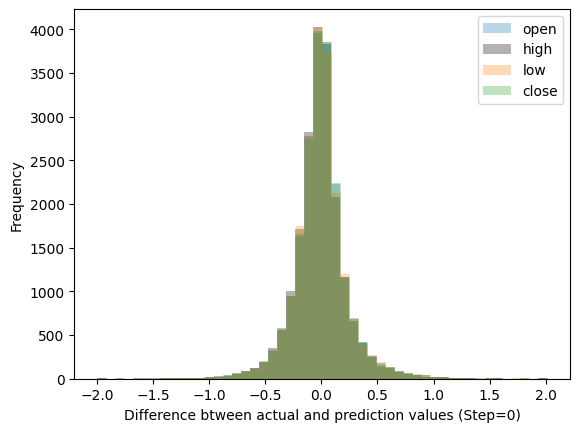

In [104]:
import matplotlib.pyplot as plt

if batch_first:
    get_feature_by_step = lambda array, step, feature_dim: array[:,step, feature_dim]
else:
    get_feature_by_step = lambda array, step, feature_dim: array[step, :, feature_dim]
    
step=0
plt.hist(get_feature_by_step(diff_array, step, 0), bins=50, alpha=0.3)
plt.hist(get_feature_by_step(diff_array, step, 1), bins=50, alpha=0.3, color="black")
plt.hist(get_feature_by_step(diff_array, step, 2), bins=50, alpha=0.3)
plt.hist(get_feature_by_step(diff_array, step, 3), bins=50, alpha=0.3)
plt.xlabel(f'Difference btween actual and prediction values (Step={step})')
plt.ylabel('Frequency')
plt.legend(['open', 'high', "low", "close"])
plt.plot()

[]

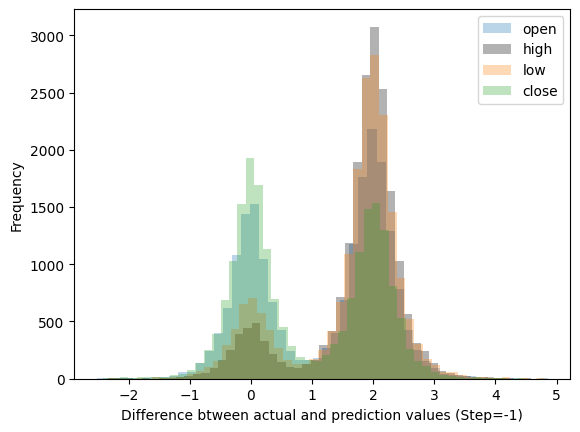

In [105]:
step=-1
plt.hist(get_feature_by_step(diff_array, step, 0), bins=50, alpha=0.3)
plt.hist(get_feature_by_step(diff_array, step, 1), bins=50, alpha=0.3, color="black")
plt.hist(get_feature_by_step(diff_array, step, 2), bins=50, alpha=0.3)
plt.hist(get_feature_by_step(diff_array, step, 3), bins=50, alpha=0.3)
plt.xlabel(f'Difference btween actual and prediction values (Step={step})')
plt.ylabel('Frequency')
plt.legend(['open', 'high', "low", "close"])
plt.plot()

[]

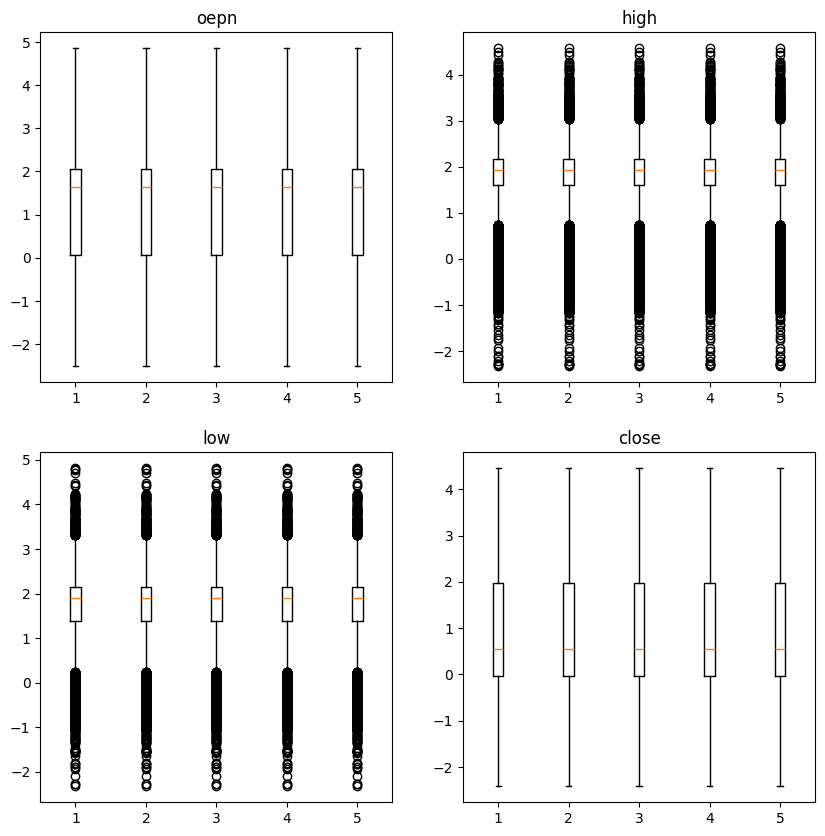

In [108]:
quant_1_df = pd.DataFrame(np.quantile(diff_array, 0.25, axis=batch_dim), columns=columns)
quant_2_df = pd.DataFrame(np.quantile(diff_array, 0.5, axis=batch_dim), columns=columns)
quant_3_df = pd.DataFrame(np.quantile(diff_array, 0.75, axis=batch_dim), columns=columns)
min_df = pd.DataFrame(np.min(diff_array, axis=batch_dim), columns=columns)
max_df = pd.DataFrame(np.max(diff_array, axis=batch_dim), columns=columns)

fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# plot quantile values with prediction steps
for index in range(0, 5):
  axs[0,0].boxplot(get_feature_by_step(diff_array, step, 0), positions=[index+1])
  axs[0,1].boxplot(get_feature_by_step(diff_array, step, 1), positions=[index+1])
  axs[1,0].boxplot(get_feature_by_step(diff_array, step, 2), positions=[index+1])
  axs[1,1].boxplot(get_feature_by_step(diff_array, step, 3), positions=[index+1])

axs[0,0].set_title('oepn')
axs[0,1].set_title('high')
axs[1,0].set_title('low')
axs[1,1].set_title('close')
plt.plot()

[]

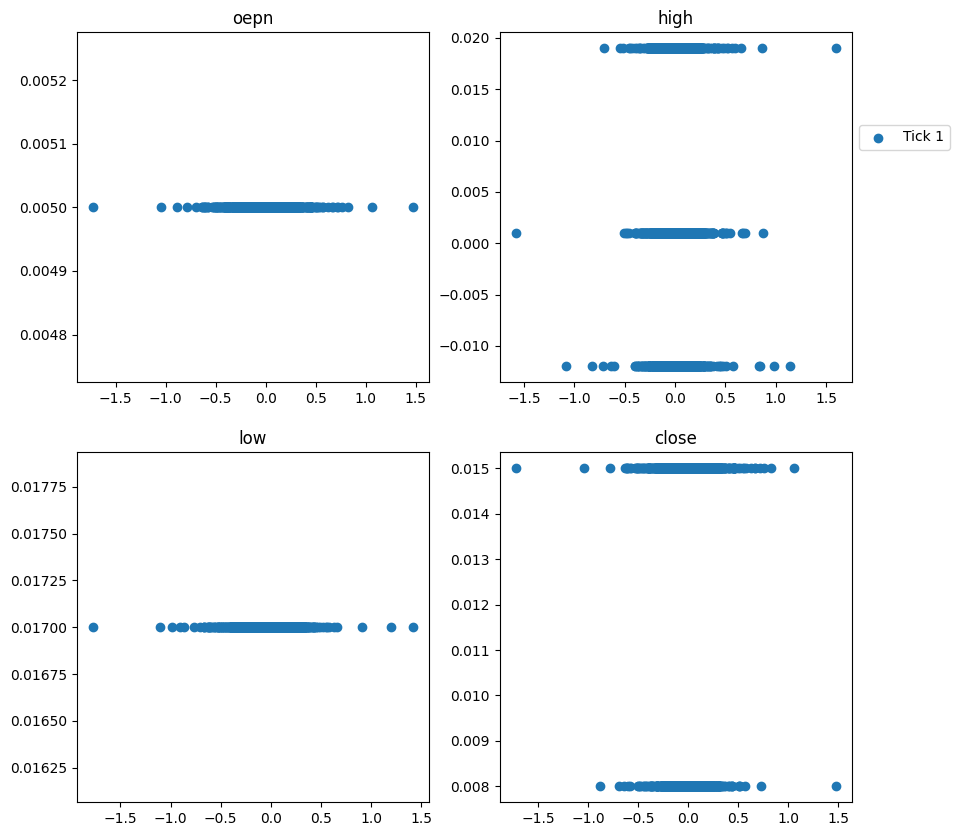

In [115]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

ans_ohlc_diff = np.diff(ans_ohlc, axis=len_dim)

axs[0,0].scatter(get_feature_by_step(ans_ohlc_diff, 0, 0), get_feature_by_step(pre_ohlc_diff, 1, 0), label=f'Tick {1}')
axs[0,1].scatter(get_feature_by_step(ans_ohlc_diff, 0, 1), get_feature_by_step(pre_ohlc_diff, 1, 1), label=f'Tick {1}')
axs[1,0].scatter(get_feature_by_step(ans_ohlc_diff, 0, 2), get_feature_by_step(pre_ohlc_diff, 1, 2), label=f'Tick {1}')
axs[1,1].scatter(get_feature_by_step(ans_ohlc_diff, 0, 3), get_feature_by_step(pre_ohlc_diff, 1, 3), label=f'Tick {1}')
axs[0,0].set_title('oepn')
axs[0,1].set_title('high')
axs[1,0].set_title('low')
axs[1,1].set_title('close')

axs[0, 1].legend(loc='center left', bbox_to_anchor=(1, 0.7))
plt.plot()

[]

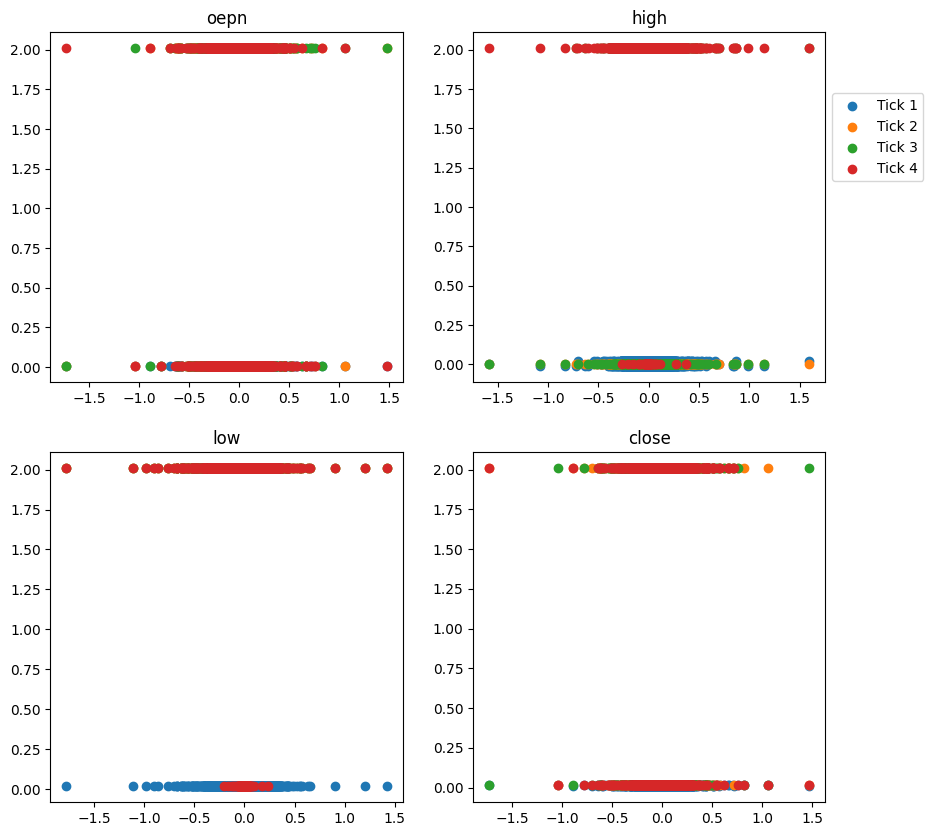

In [116]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

for step in range(1, 5):
  axs[0,0].scatter(get_feature_by_step(ans_ohlc_diff, step-1, 0), get_feature_by_step(pre_ohlc_diff, step, 0), label=f'Tick {step}')
  axs[0,1].scatter(get_feature_by_step(ans_ohlc_diff, step-1, 1), get_feature_by_step(pre_ohlc_diff, step, 1), label=f'Tick {step}')
  axs[1,0].scatter(get_feature_by_step(ans_ohlc_diff, step-1, 2), get_feature_by_step(pre_ohlc_diff, step, 2), label=f'Tick {step}')
  axs[1,1].scatter(get_feature_by_step(ans_ohlc_diff, step-1, 3), get_feature_by_step(pre_ohlc_diff, step, 3), label=f'Tick {step}')
axs[0,0].set_title('oepn')
axs[0,1].set_title('high')
axs[1,0].set_title('low')
axs[1,1].set_title('close')
axs[0, 1].legend(loc='center left', bbox_to_anchor=(1, 0.7))
plt.plot()

In [117]:
if batch_first:
    diff_array_org = pre_ohlc_diff[:, 1:] - ans_ohlc_diff
else:
    diff_array_org = pre_ohlc_diff[1:] - ans_ohlc_diff
mean_org_df = pd.DataFrame(np.mean(diff_array_org, axis=batch_dim), columns=["open", "high", "low", "close"])
var_org_df = pd.DataFrame(np.var(diff_array_org, axis=batch_dim), columns=["open", "high", "low", "close"])

print(mean_org_df)
print(var_org_df)

       open      high       low     close
0  0.003457  0.001095  0.015459  0.011160
1  1.349848 -0.000542  2.007461  1.353132
2  1.318578  1.247127  2.007162  1.353132
3  1.298996  2.002757  1.999024  1.353238
4  0.709732  1.968524  1.968039  1.291998
5  0.705832  1.957411  1.446649  0.740664
6  1.302001  1.500910  1.841516  0.983624
7  1.507514  1.785220  1.097668  0.697418
8  1.187302  1.656981  1.529079  0.846833
9  1.182972  1.732988  1.610826  0.932088
       open      high       low     close
0  0.006602  0.005383  0.006075  0.006547
1  0.890125  0.005238  0.006075  0.885152
2  0.909221  0.954894  0.006665  0.884373
3  0.923587  0.014620  0.022753  0.881423
4  0.923683  0.082131  0.082746  0.923088
5  0.920081  0.103445  0.810736  0.928529
6  0.922079  0.766731  0.309512  0.998097
7  0.760173  0.402473  0.989355  0.902762
8  0.977128  0.586780  0.730195  0.972392
9  0.980345  0.480733  0.638456  0.995085


[]

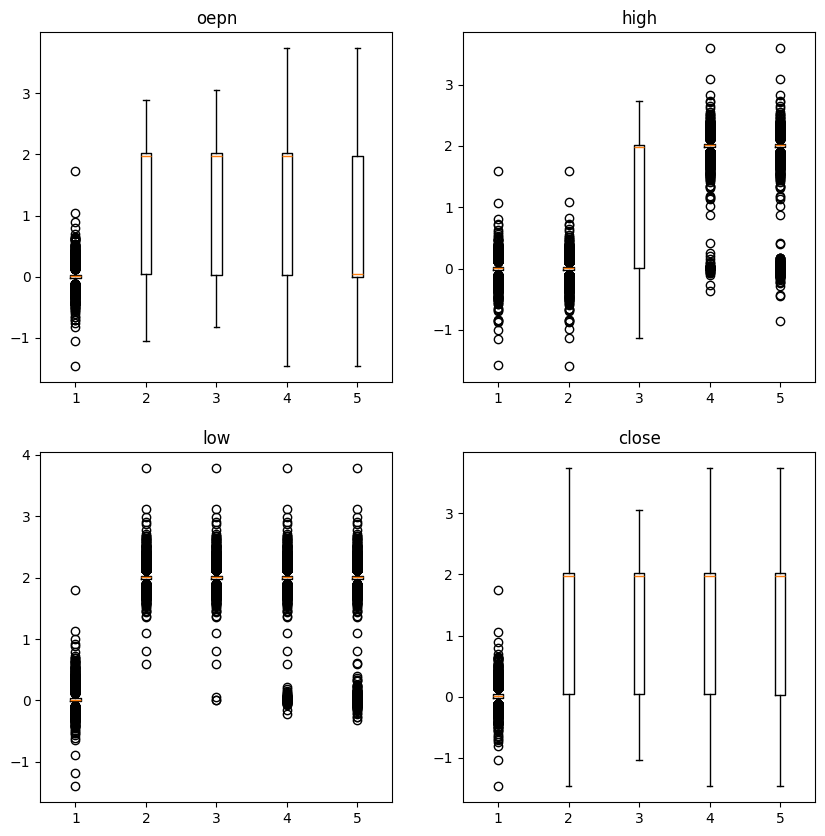

In [118]:
quant_1_org_df = pd.DataFrame(np.quantile(diff_array_org, 0.25, axis=batch_dim), columns=columns)
quant_2_org_df = pd.DataFrame(np.quantile(diff_array_org, 0.5, axis=batch_dim), columns=columns)
quant_3_org_df = pd.DataFrame(np.quantile(diff_array_org, 0.75, axis=batch_dim), columns=columns)
min_org_df = pd.DataFrame(np.min(diff_array_org, axis=batch_dim), columns=columns)
max_org_df = pd.DataFrame(np.max(diff_array_org, axis=batch_dim), columns=columns)

fig, axs = plt.subplots(2, 2, figsize=(10, 10))

for index in range(0, 5):
  axs[0,0].boxplot(get_feature_by_step(diff_array_org, index, 0), positions=[index+1])
  axs[0,1].boxplot(get_feature_by_step(diff_array_org, index, 1), positions=[index+1])
  axs[1,0].boxplot(get_feature_by_step(diff_array_org, index, 2), positions=[index+1])
  axs[1,1].boxplot(get_feature_by_step(diff_array_org, index, 3), positions=[index+1])

axs[0,0].set_title('oepn')
axs[0,1].set_title('high')
axs[1,0].set_title('low')
axs[1,1].set_title('close')
plt.plot()

In [119]:
validation_file_path = f'{base_folder}/{model_name}/{model_name}_v{model_version}_validation.csv'
validation_df = pd.concat([
    mean_df, var_df, quant_1_df, quant_2_df, quant_3_df, min_df, max_df,
    mean_org_df, var_org_df, quant_1_org_df, quant_2_org_df, quant_3_org_df, min_org_df, max_org_df,
    ],
    keys=[
        "mean", "var", "q1", "q2", "q3", "min", "max",
        "org_mean", "org_var", "org_q1", "org_q2", "org_q3", "org_min", "org_max"
        ],
    axis=1)
os.makedirs(os.path.dirname(validation_file_path), exist_ok=True)
validation_df.to_csv(validation_file_path)
if storage_handler is not None:
    destination_file_path = f'/{model_name}/{model_name}_v{model_version}_validation.csv'
    storage_handler.upload_file(validation_file_path, destination_file_path)

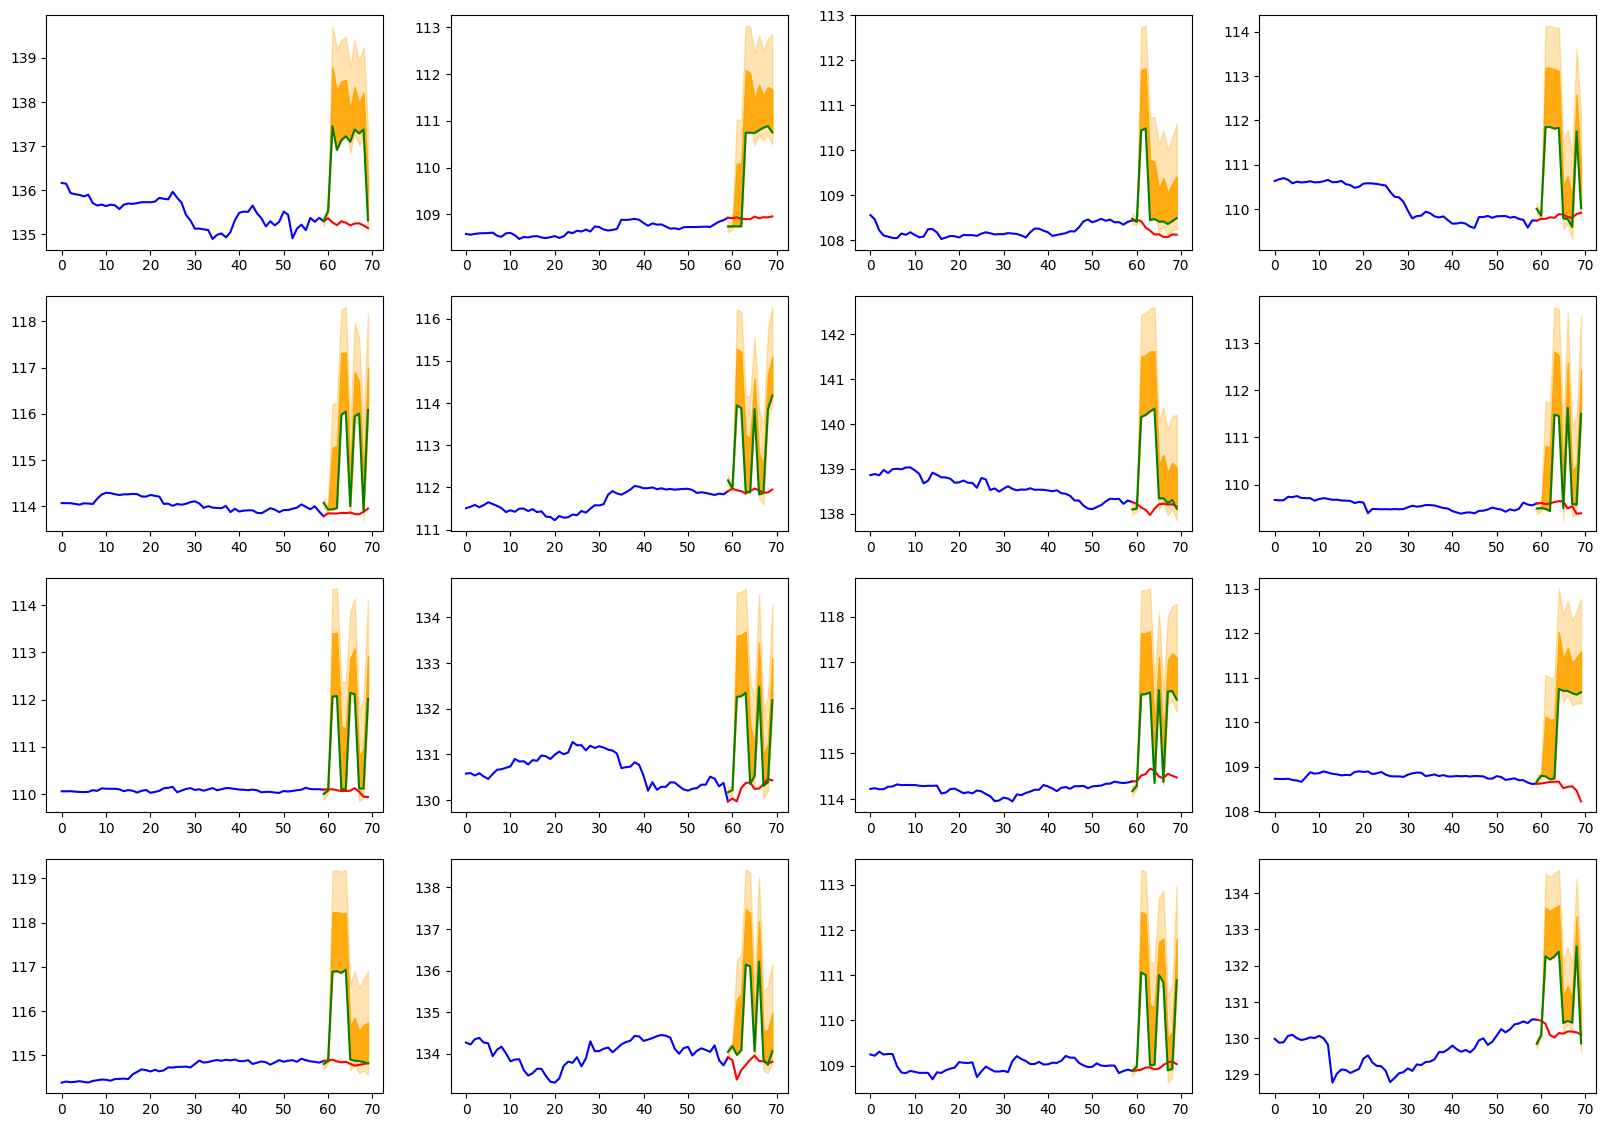

In [120]:
fig, axs = plt.subplots(4, 4, figsize=(20, 14))
close_mean = np.mean(pre_ohlc[:, :, 3]-ans_ohlc[:, :, 3], axis=batch_dim)
close_var = np.var(pre_ohlc[:, :, 3]-ans_ohlc[:, :, 3], axis=batch_dim)

total_length = observation_length + prediction_length
x = np.arange(total_length)

for batch_index, ax in enumerate(axs.flat):
    index = ds.get_actual_index(batch_index)
    original_ohlc = df[ohlc_column[3]].iloc[index: index + observation_length]
    if batch_first:
        pred_value = pre_ohlc[batch_index, :, 3]
        ans_value = ans_ohlc[batch_index, :, 3]
    else:
        pred_value = pre_ohlc[:, batch_index, 3]
        ans_value = ans_ohlc[:, batch_index, 3]
    pred_add_mean = pred_value + close_mean
    pred_upper = pred_add_mean + close_var
    pred_lower = pred_add_mean - close_var

    ax.fill_between(x[observation_length -1:], pred_value, pred_add_mean, color="orange", alpha=0.9)
    ax.fill_between(x[observation_length -1:], pred_lower, pred_upper, color="orange", alpha=0.3)
    ax.plot(x[:observation_length], original_ohlc, color="blue")
    ax.plot(x[observation_length-1:], ans_value, color="red")
    ax.plot(x[observation_length-1:], pred_value, color="green")
plt.show()